<h1 id="intro">Explore here</h1>
<a href="#current">Go cell below</a>

In [33]:
import pandas as pd 
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from pickle import dump

### 1. Reading the dataset

In [2]:
total_data = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/machine-learning-content/master/assets/spam.csv')
total_data.head()  

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 2. Data Processing

In [9]:
# count the number of spam and ham messages
print(total_data['Category'].value_counts())
print('*'*50)
print(total_data.shape)

Category
0    4825
1     747
Name: count, dtype: int64
**************************************************
(5572, 2)


#### Categorical to numerical transformation

In [4]:
# Using a lambda function, transform the Category column to binary where spam = 1 and ham = 0
total_data['Category'] = total_data['Category'].apply(lambda x: 1 if x == 'spam' else 0).astype('int') # astype('int') is used to convert the boolean values to integers
total_data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#### Elimination of repeated values

In [10]:
# Elimination of repeated values in the dataset
total_data = total_data.drop_duplicates()
total_data = total_data.reset_index(inplace= False ,drop=True)
total_data.shape

(5157, 2)

#### Text processing

In [12]:
# Text processing: apply transformation process to the text using regex
def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split() # return a list of words

total_data['Message'] = total_data['Message'].apply(preprocess_text)
total_data.head()

,Category,Message
0,0,"[until, jurong, point, crazy, vailable, only, ..."
1,0,"[lar, oking, wif, oni]"
2,1,"[ree, entry, in, wkly, comp, to, win, up, fina..."
3,0,"[dun, say, so, early, hor, already, then, say]"
4,0,"[ah, don, think, he, goes, to, usf, he, lives,..."


The next step is lemmatization of the text, which is the process of simplifying words to their base or canonical form, so that words with different forms but the same semantic core are treated as a single word. For example, the verbs "running", "ran" and "runs" will be lemmatized to "run", just as the words "best" and "best" could be lemmatized to "good".

In addition, taking advantage of lemmatization, we will also eliminate stopwords, which are words that we consider irrelevant for text analysis because they appear very frequently in the language and do not provide meaningful information. There are two ways: either we create our own list of words to eliminate or we use external libraries. 

In [18]:
download('wordnet') # WordNet is a lexical database for the English language that helps the script determine the base word
download('stopwords') # Stopwords are the English words which does not add much meaning to a sentence, they are ignored without sacrificing the meaning of the sentence (example, he, have, at...)
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

total_data['Message'] = total_data['Message'].apply(lemmatize_text)
total_data.head()
""" 
The above function can also be written as:
def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = []
    for word in words:
        if word not in stop_words:
            tokens.append(lemmatizer.lemmatize(word))
    return tokens
total_data['Message'] = total_data['Message'].apply(lemmatize_text)
total_data.head()
"""

[nltk_data] Downloading package wordnet to C:\Users\Jorge
[nltk_data]     Payà\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jorge
[nltk_data]     Payà\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Category,Message
0,0,"[jurong, point, crazy, vailable, bugis, great,..."
1,0,[oking]
2,1,"[entry, wkly, comp, final, tkts, receive, entr..."
3,0,"[early, already]"
4,0,"[think, life, around, though]"


Something very common once we have the tokens is to represent them in a word cloud. A word cloud is a visual representation of the words that make up a text, where the size of each word indicates its frequency or importance in the text.

This visual representation allows us to quickly identify the most relevant or repeated terms or concepts in a dataset, since the most frequent or significant words stand out by their size. We can easily implement it using the wordcloud library for Python:

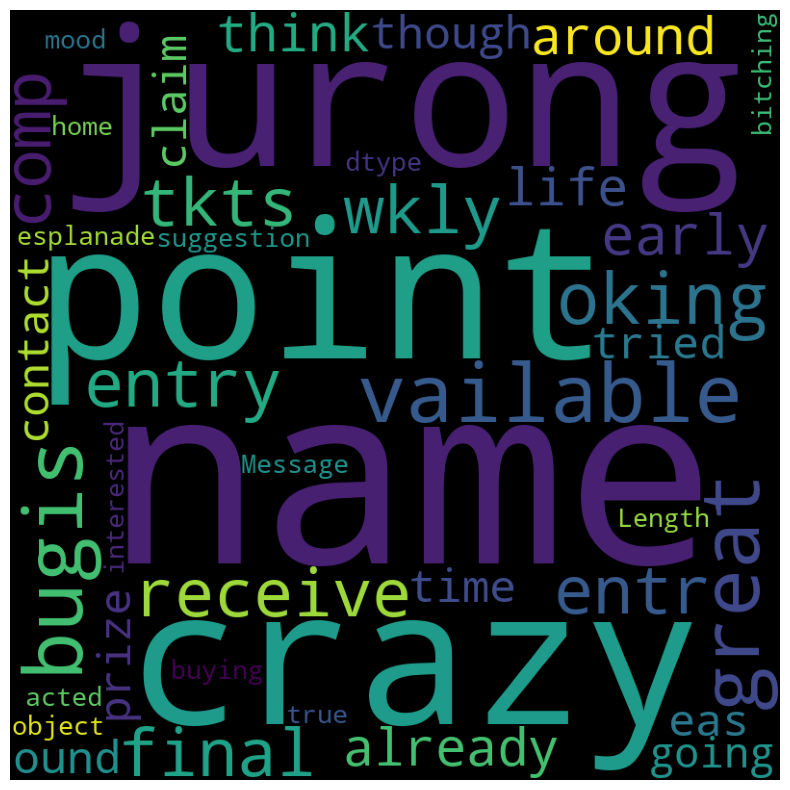

In [21]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', 
                      max_words = 1000, min_font_size = 20, random_state = 42).generate(str(total_data['Message']))
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The last step before training the model is to convert it into numbers, since models cannot be trained with textual categories. In previous modules we saw how we could transform text into numeric vectors using the CountVectorizer of scikit-learn, but here we will apply a new process:

In [25]:
tokens_list = total_data['Message']
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, min_df = 5, max_df = 0.8)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["Category"]
X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

- The <b>TfiedVectorizer</b> from <b>sklearn.feature_extraction.text</b> module to convert a collection of raw documents to a matrix of TF-IDF features. TF-IDF stands for Term Frequency-Inverse Document Frequency, a numerical statistic that reflects how important a word is to a document in a collection or corpus.
- tokens_list = total_data['Message']: This line is extracting the 'Message' column from the total_data DataFrame and assigning it to tokens_list.
- tokens_list = [" ".join(tokens) for tokens in tokens_list]: This line is joining all the tokens in each list of tokens_list into a single string. This is done because the TfidfVectorizer expects its input to be a collection of strings where each string is a document.
- vectorizer = TfidfVectorizer(max_features = 5000, min_df = 5, max_df = 0.8): This line is initializing a TfidfVectorizer object. The max_features parameter is set to 5000, which means that it will only consider the top 5000 terms ordered by term frequency across the corpus. The min_df parameter is set to 5 which means that a word must be included in at least 5 documents from the corpus to be considered. The max_df parameter is set to 0.8; terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words) will be ignored.
- X = vectorizer.fit_transform(tokens_list).toarray(): This line is fitting the TfidfVectorizer to tokens_list and then transforming tokens_list into a TF-IDF matrix. The toarray() method is used to convert the matrix to a numpy array. This array X is typically used as features in a machine learning model.
- y = total_data["Category"]: This line is extracting the 'Category' column from the total_data DataFrame and assigning it to y. This y could be used as the target in a machine learning model.
- X[:5]: This line is printing the first 5 rows of the TF-IDF matrix.

TfidfVectorizer converts a collection of raw text documents into a TF-IDF feature matrix. TF-IDF is a measure that quantifies the importance of a word in a document relative to a corpus. It is composed of two terms:

- TF (Term Frequency): it is the frequency of a word in a document.
- IDF (Inverse Document Frequency): Measures the importance of the term in the corpus. A term that appears in many documents may not be as informative.

Therefore, by using TfidfVectorizer, we transform a collection of text documents into a numerical matrix representing the relative importance of each word in each document, relative to the entire corpus. This matrix is commonly used as input for machine learning algorithms, especially in natural language processing tasks such as text classification.

#### Train Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### 3. Initialization and training of the model

In [29]:
model = SVC(kernel = 'linear', random_state=42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

#### 4. Model prediction

In [30]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
accuracy_score(y_test, y_pred)

0.9748062015503876

### 5. Saving the model

In [35]:
dump(model, open('C:/Users/Jorge Payà/Desktop/4Geeks/DSML Bootcamp/NLP-projects/models/spam_classifier_linear_42.sav', 'wb'))

<a href="#intro"><span style="color: green">Go Up</span></a><br>
<span id="current"><a>Current</a></span>